In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils
import scipy.signal as signal


from matplotlib.lines import Line2D
import matplotlib.patches as mpatches


import string
alphabet = list(string.ascii_lowercase)
          

## Data

Data for this is from https://gmd.copernicus.org/articles/11/1133/2018/ CDRMIP data, where pi-CO2pulse is the 100GtC pulse and piControl is the control

In [2]:
G_ds = xr.open_dataset('Outputs/G_ds.nc4')['__xarray_dataarray_variable__']
G_mean_ds = xr.open_dataset('Outputs/G_mean_ds.nc4')['__xarray_dataarray_variable__']
G_cdr_ds = xr.open_dataset('Outputs/G_cdr_ds.nc4')['__xarray_dataarray_variable__']
G_cdr_mean_ds = xr.open_dataset('Outputs/G_cdr_mean_ds.nc4')['__xarray_dataarray_variable__']

In [3]:
G_ds = xr.concat([G_ds, -G_cdr_ds], pd.Index(['pulse','cdr'], name = 'pulse_type'))
G_mean_ds = xr.concat([G_mean_ds, -G_cdr_mean_ds], pd.Index(['pulse','cdr'], name = 'pulse_type'))

In [4]:
G_ds = G_ds.rename({'year':'s'})
G_mean_ds = G_mean_ds.rename({'year':'s'})

In [5]:
A = utils.A

In [6]:
model_color = utils.model_color

In [7]:
type_color = utils.type_color

In [8]:
model_weights = utils.model_weights

In [9]:
ds_dif = xr.open_dataset('Outputs/ds_dif.nc4')

## Global Mean plots

In [10]:
roll_amt_color_dict = {5:'goldenrod',10: 'forestgreen', 30:'darkblue'}

(0.0, 90.0)

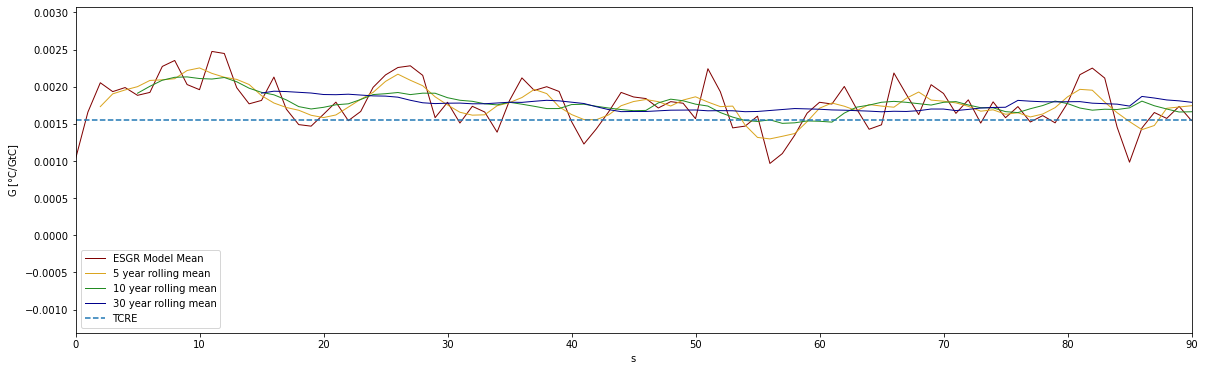

In [44]:
fig, ax = plt.subplots(figsize = [20,6])
plt.title('Annual Mean', fontsize = 16)
plt.xlim(G_ds.s.min(), G_ds.s[140].values)

G_ds.weighted(A).mean(dim = ['lat','lon']).mean(dim = ['model','pulse_type']).plot(label = 'ESGR Model Mean', color = 'maroon', linewidth = 1)

G_ds.rolling(s = 5, center = True).mean().weighted(A).mean(dim = ['lat','lon']).mean(dim = ['model','pulse_type']).plot(label = '5 year rolling mean', color = 'goldenrod', linewidth = 1)
G_ds.rolling(s = 10, center = True).mean().weighted(A).mean(dim = ['lat','lon']).mean(dim = ['model','pulse_type']).plot(label = '10 year rolling mean', color = 'forestgreen', linewidth = 1)
G_ds.rolling(s = 30, center = True).mean().weighted(A).mean(dim = ['lat','lon']).mean(dim = ['model','pulse_type']).plot(label = '30 year rolling mean', color = 'darkblue', linewidth = 1)


plt.axhline(0.00155475, linestyle = '--', label = 'TCRE')
plt.ylabel('G [$\degree$C/GtC]')
plt.legend()
plt.xlim(0,90)
#plt.savefig('figures/GF_dev/all_models_monthly.png', bbox_inches = 'tight', dpi = 350)


# Compare 1pct scenario across the rolling means

In [12]:
emis_profile = xr.open_dataset(f'Outputs/1pct_emis_profile_full.nc4')
emis_profile = emis_profile.rename({'__xarray_dataarray_variable__':'emis'})

# Plots of the Convolution difference for rolling means



## Convolution

In [13]:
%%time
GF = G_ds.weighted(A).mean(dim = ['lat','lon'])

conv_1pct_mean = {}
for m1 in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'NORESM2',
   'GFDL', 'MIROC', 'CANESM5_r1p2', 'CANESM5_r2p2', 'ACCESS', 'CANESM5_r3p2']:
    conv_1pct_mean[m1] = {}
    for t in ['pulse','cdr']:
        if m1 == 'UKESM1_r1' or m1 == 'UKESM1_r2' or m1 == 'UKESM1_r3' or m1 == 'UKESM1_r4':
            m2 = 'UKESM1_r1'
        else:
            m2 = m1
        conv_1pct_mean[m1][t] = signal.convolve( np.array(GF.sel(model = m2, pulse_type = t).dropna(dim = 's')), np.array(emis_profile.sel(model = m1)['emis']),'full')
        conv_1pct_mean[m1][t] = utils.np_to_xr_mean(conv_1pct_mean[m1][t], GF.sel(model = m2, pulse_type = t), emis_profile.sel(model = m1))


CPU times: user 1.79 s, sys: 520 ms, total: 2.31 s
Wall time: 2.31 s


In [14]:
%%time
GF = G_ds.weighted(A).mean(dim = ['lat','lon'])

conv_1pct_mean_rolling = {}
for roll_amt in [5,10,30]:
    conv_1pct_mean_rolling[roll_amt] = {}
    for m1 in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'NORESM2',
       'GFDL', 'MIROC', 'CANESM5_r1p2', 'CANESM5_r2p2', 'ACCESS', 'CANESM5_r3p2']:
        conv_1pct_mean_rolling[roll_amt][m1] = {}
        for t in ['pulse','cdr']:
            if m1 == 'UKESM1_r1' or m1 == 'UKESM1_r2' or m1 == 'UKESM1_r3' or m1 == 'UKESM1_r4':
                m2 = 'UKESM1_r1'
            else:
                m2 = m1
            conv_1pct_mean_rolling[roll_amt][m1][t] = signal.convolve(np.array(GF.sel(model = m2, pulse_type = t).rolling(s = roll_amt, center = True).mean('s').dropna(dim = 's')), np.array(emis_profile.sel(model = m1)['emis']),'full')
            conv_1pct_mean_rolling[roll_amt][m1][t] = utils.np_to_xr_mean(conv_1pct_mean_rolling[roll_amt][m1][t], GF.sel(model = m2, pulse_type = t).rolling(s = roll_amt, center = True).mean('s'), emis_profile.sel(model = m1))


CPU times: user 2.51 s, sys: 507 ms, total: 3.02 s
Wall time: 3.03 s


In [15]:
#convert to dataset

conv_1pct_dict = {}
for m in conv_1pct_mean.keys():
    conv_1pct_dict[m] = xr.concat([conv_1pct_mean[m][t] for t in conv_1pct_mean[m].keys()], pd.Index([t for t in conv_1pct_mean[m].keys()], name='pulse_type'), coords='minimal')
conv_1pct_mean_ds = xr.concat([conv_1pct_dict[m] for m in conv_1pct_dict.keys()], pd.Index([m for m in conv_1pct_dict.keys()], name='model'), coords='minimal')




In [16]:
#convert to dataset

conv_1pct_rolling_dict = {}
conv_1pct_mean_rolling_ds = {}
for roll_amt in [5,10,30]:
    conv_1pct_rolling_dict[roll_amt] = {}
    for m in conv_1pct_mean_rolling[roll_amt].keys():

        conv_1pct_rolling_dict[roll_amt][m] = xr.concat([conv_1pct_mean_rolling[roll_amt][m][t] for t in conv_1pct_mean_rolling[roll_amt][m].keys()], pd.Index([t for t in conv_1pct_mean_rolling[roll_amt][m].keys()], name='pulse_type'), coords='minimal')
    conv_1pct_mean_rolling_ds[roll_amt] = xr.concat([conv_1pct_rolling_dict[roll_amt][m] for m in conv_1pct_rolling_dict[roll_amt].keys()], pd.Index([m for m in conv_1pct_rolling_dict[roll_amt].keys()], name='model'), coords='minimal')


Text(0, 0.5, '$\\Delta$T ($\\degree$C)')

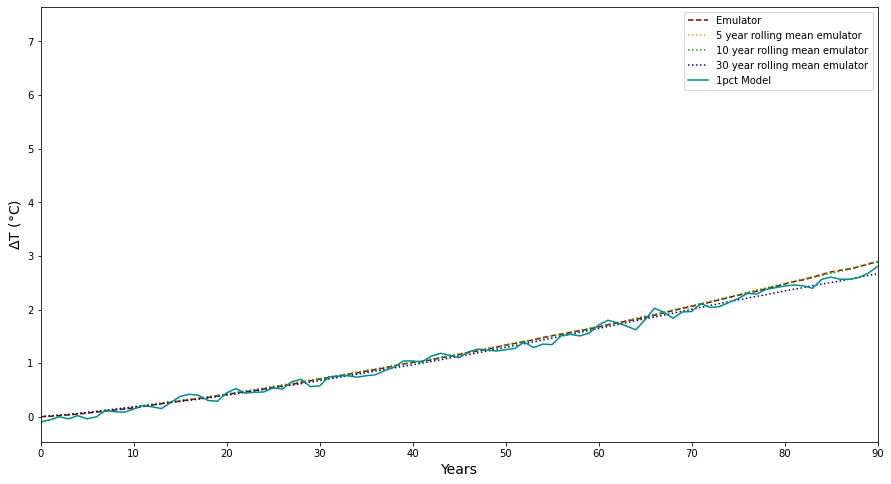

In [68]:
fig, ax = plt.subplots(figsize = (15,8))

plt.plot(conv_1pct_mean_ds.weighted(model_weights).mean(dim = ['model', 'pulse_type']), label = f'Emulator', color = type_color['emulator_1pct'], linestyle = '--')

for roll_amt in [5,10,30]:
    plt.plot(conv_1pct_mean_rolling_ds[roll_amt].weighted(model_weights).mean(dim = ['model', 'pulse_type']), label = f'{roll_amt} year rolling mean emulator', 
             color = roll_amt_color_dict[roll_amt], linestyle = ':')


plt.plot(np.arange(0,len(ds_dif['s'])), ds_dif.sel(experiment = '1pct').weighted(model_weights).mean(dim = 'model').weighted(A).mean(dim = ['lat','lon'])['tas'], 
         label = '1pct Model', color = type_color['model_1pct'])
plt.legend()
plt.xlim(0,90)
plt.xlabel('Years', fontsize = 14)
plt.ylabel('$\Delta$T ($\degree$C)', fontsize = 14)
#plt.savefig('figures/1pct_increase/model_mean_convolution_vs_1pct.png', bbox_inches = 'tight', dpi = 350)


## Convolution of pattern/spatial

In [17]:
%%time
GF = G_ds

conv_1pct = {}
for m1 in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'NORESM2',
   'GFDL', 'MIROC', 'CANESM5_r1p2', 'CANESM5_r2p2', 'ACCESS', 'CANESM5_r3p2']:
    conv_1pct[m1] = {}
    for t in ['pulse','cdr']:
        if m1 == 'UKESM1_r1' or m1 == 'UKESM1_r2' or m1 == 'UKESM1_r3' or m1 == 'UKESM1_r4':
            m2 = 'UKESM1_r1'
        else:
            m2 = m1
        conv_1pct[m1][t] = signal.convolve( np.array(GF.sel(model = m2, pulse_type = t).dropna(dim = 's')), np.array(emis_profile.sel(model = m1)['emis'])[..., None, None],'full')
        conv_1pct[m1][t] = utils.np_to_xr(conv_1pct[m1][t], GF.sel(model = m2, pulse_type = t), emis_profile.sel(model = m1))


CPU times: user 9.58 s, sys: 4.81 s, total: 14.4 s
Wall time: 14.4 s


In [18]:
%%time
GF = G_ds

conv_1pct_rolling = {}
for roll_amt in [5,10,30]:
    conv_1pct_rolling[roll_amt] = {}
    for m1 in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'NORESM2',
       'GFDL', 'MIROC', 'CANESM5_r1p2', 'CANESM5_r2p2', 'ACCESS', 'CANESM5_r3p2']:
        conv_1pct_rolling[roll_amt][m1] = {}
        for t in ['pulse','cdr']:
            if m1 == 'UKESM1_r1' or m1 == 'UKESM1_r2' or m1 == 'UKESM1_r3' or m1 == 'UKESM1_r4':
                m2 = 'UKESM1_r1'
            else:
                m2 = m1
            conv_1pct_rolling[roll_amt][m1][t] = signal.convolve(np.array(GF.sel(model = m2, pulse_type = t).rolling(s = roll_amt, center = True).mean('s').dropna(dim = 's')), np.array(emis_profile.sel(model = m1)['emis'])[..., None, None],'full')
            conv_1pct_rolling[roll_amt][m1][t] = utils.np_to_xr(conv_1pct_rolling[roll_amt][m1][t], GF.sel(model = m2, pulse_type = t).rolling(s = roll_amt, center = True).mean('s'), emis_profile.sel(model = m1))


CPU times: user 2min 23s, sys: 48.6 s, total: 3min 11s
Wall time: 3min 12s


In [19]:
#convert to dataset

conv_1pct_dict = {}
for m in conv_1pct_mean.keys():
    conv_1pct_dict[m] = xr.concat([conv_1pct[m][t] for t in conv_1pct[m].keys()], pd.Index([t for t in conv_1pct[m].keys()], name='pulse_type'), coords='minimal')
conv_1pct_ds = xr.concat([conv_1pct_dict[m] for m in conv_1pct_dict.keys()], pd.Index([m for m in conv_1pct_dict.keys()], name='model'), coords='minimal')




In [20]:
#convert to dataset

conv_1pct_rolling_dict = {}
conv_1pct_rolling_ds = {}
for roll_amt in [5,10,30]:
    conv_1pct_rolling_dict[roll_amt] = {}
    for m in conv_1pct_rolling[roll_amt].keys():

        conv_1pct_rolling_dict[roll_amt][m] = xr.concat([conv_1pct_rolling[roll_amt][m][t] for t in conv_1pct_rolling[roll_amt][m].keys()], pd.Index([t for t in conv_1pct_rolling[roll_amt][m].keys()], name='pulse_type'), coords='minimal')
    conv_1pct_rolling_ds[roll_amt] = xr.concat([conv_1pct_rolling_dict[roll_amt][m] for m in conv_1pct_rolling_dict[roll_amt].keys()], pd.Index([m for m in conv_1pct_rolling_dict[roll_amt].keys()], name='model'), coords='minimal')


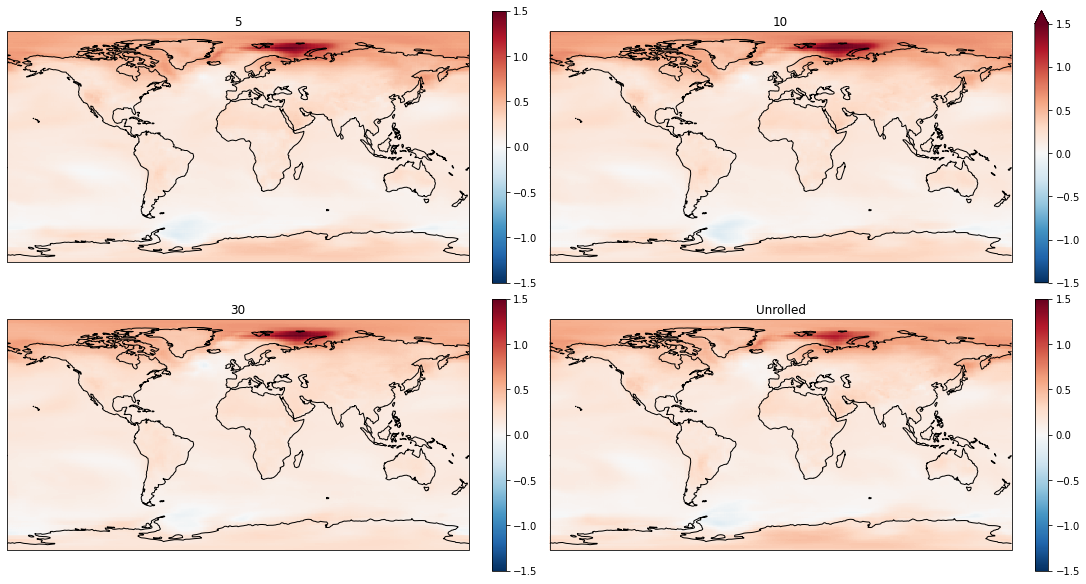

In [39]:
t = 10
dif_t = 5

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize = [15,8], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)

#rolled
for roll_amt, ax in zip([5,10,30], [ax1, ax2, ax3]):
    conv_1pct_rolling_ds[roll_amt].weighted(model_weights).mean(dim = ['model','pulse_type']).sel(s = slice(t-dif_t,t+dif_t)).mean(dim = 's').plot(ax = ax,  
                                                                                                  transform = ccrs.PlateCarree(),
                                                                                                vmax = 1.5, vmin = -1.5,
                                                                                                cmap = 'RdBu_r')
    ax.set_title(roll_amt)
    
    ax.coastlines()
#unrolled
conv_1pct_ds.weighted(model_weights).mean(dim = ['model','pulse_type']).sel(s = slice(t-dif_t,t+dif_t)).mean(dim = 's').plot(ax = ax4,  
                                                                                                  transform = ccrs.PlateCarree(),
                                                                                                vmax = 1.5, vmin = -1.5,
                                                                                                cmap = 'RdBu_r')  
ax4.set_title('Unrolled')

ax4.coastlines()


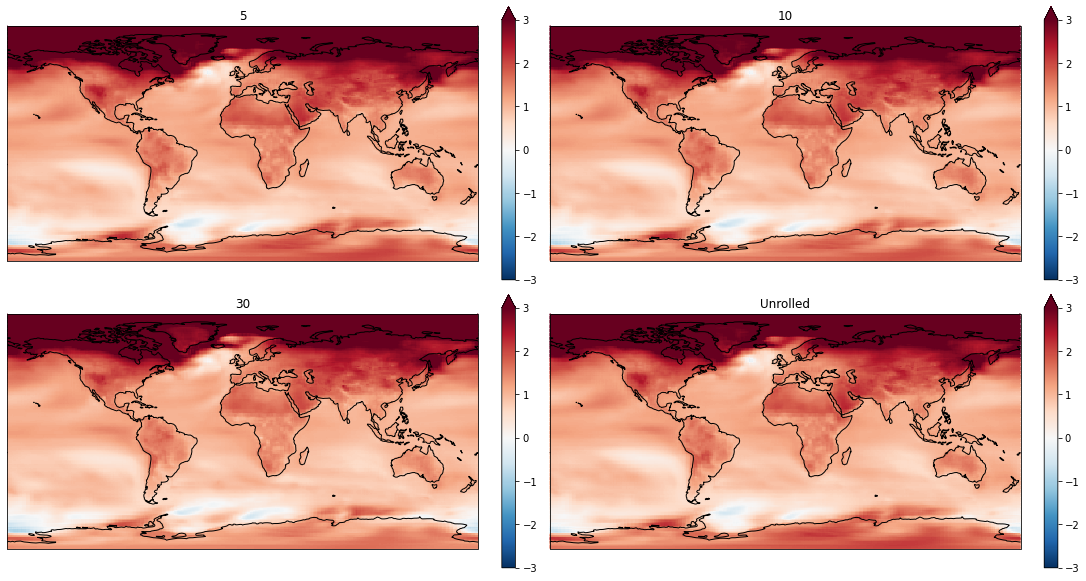

In [40]:
t = 50
dif_t = 5

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize = [15,8], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)

#rolled
for roll_amt, ax in zip([5,10,30], [ax1, ax2, ax3]):
    conv_1pct_rolling_ds[roll_amt].weighted(model_weights).mean(dim = ['model','pulse_type']).sel(s = slice(t-dif_t,t+dif_t)).mean(dim = 's').plot(ax = ax,  
                                                                                                  transform = ccrs.PlateCarree(),
                                                                                                vmax = 3.0, vmin = -3.0,
                                                                                                cmap = 'RdBu_r')
    ax.set_title(roll_amt)
    
    ax.coastlines()
#unrolled
conv_1pct_ds.weighted(model_weights).mean(dim = ['model','pulse_type']).sel(s = slice(t-dif_t,t+dif_t)).mean(dim = 's').plot(ax = ax4,  
                                                                                                  transform = ccrs.PlateCarree(),
                                                                                                vmax = 3.0, vmin = -3.0,
                                                                                                cmap = 'RdBu_r')  
ax4.set_title('Unrolled')

ax4.coastlines()


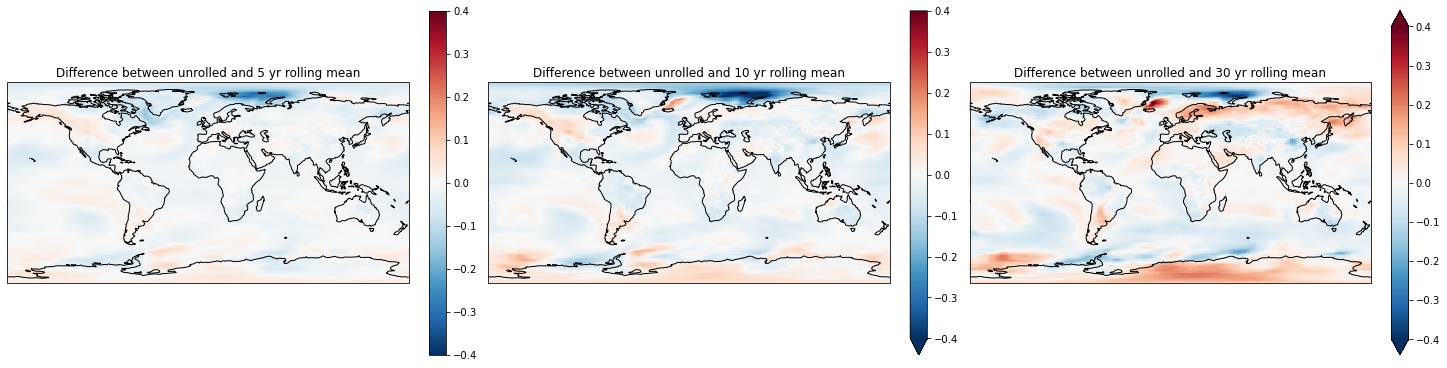

In [41]:
t = 10
dif_t = 5

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize = [20,5], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)
conv_1pct_ds.weighted(model_weights).mean(dim = ['model','pulse_type']).sel(s = slice(t-dif_t,t+dif_t)).mean(dim = 's')
#rolled
for roll_amt, ax in zip([5,10,30], [ax1, ax2, ax3]):
    (conv_1pct_ds - conv_1pct_rolling_ds[roll_amt]).weighted(model_weights).mean(dim = ['model','pulse_type']).sel(s = slice(t-dif_t,t+dif_t)).mean(dim = 's').plot(ax = ax,  
                                                                                                  transform = ccrs.PlateCarree(), 
                                                                                                  vmin = -0.4, vmax = 0.4, cmap = 'RdBu_r')
    ax.set_title(f'Difference between unrolled and {roll_amt} yr rolling mean')
    
    ax.coastlines()


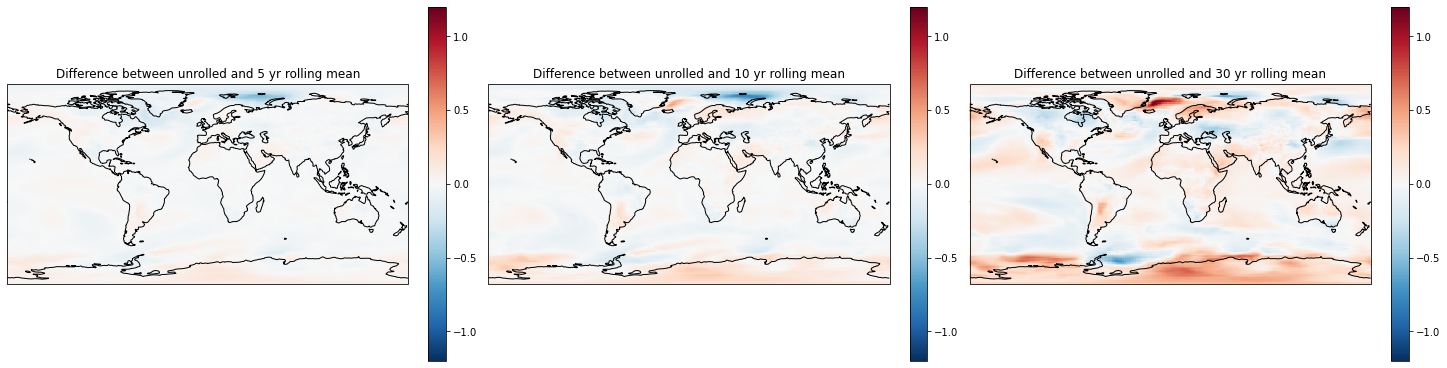

In [43]:
t = 50
dif_t = 5

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize = [20,5], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)
conv_1pct_ds.weighted(model_weights).mean(dim = ['model','pulse_type']).sel(s = slice(t-dif_t,t+dif_t)).mean(dim = 's')
#rolled
for roll_amt, ax in zip([5,10,30], [ax1, ax2, ax3]):
    (conv_1pct_ds - conv_1pct_rolling_ds[roll_amt]).weighted(model_weights).mean(dim = ['model','pulse_type']).sel(s = slice(t-dif_t,t+dif_t)).mean(dim = 's').plot(ax = ax,  
                                                                                                  transform = ccrs.PlateCarree(), 
                                                                                                  vmin = -1.2, vmax = 1.2, cmap = 'RdBu_r')
    ax.set_title(f'Difference between unrolled and {roll_amt} yr rolling mean')
    
    ax.coastlines()
